This utilises both tensorflow and xgboost to make a stacking model with level 0 and level 1 models.

This means dividing the dataset into 3 in order to validate: 

Portion | 50% | 40% | 10%
---|---|---|---
Funciton | Train L0 | Test L0 & Train L1 | Test L1

For L0 we utilize both xgboost and a Neural Network from tensorflow
For L1 we test both and try to find the best. 

# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [4]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118664], dtype='int64')
136244


Same problem for B-set at `2022-05-02 23:00:00` and C-set at `2022-04-25 21:00:00`

In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

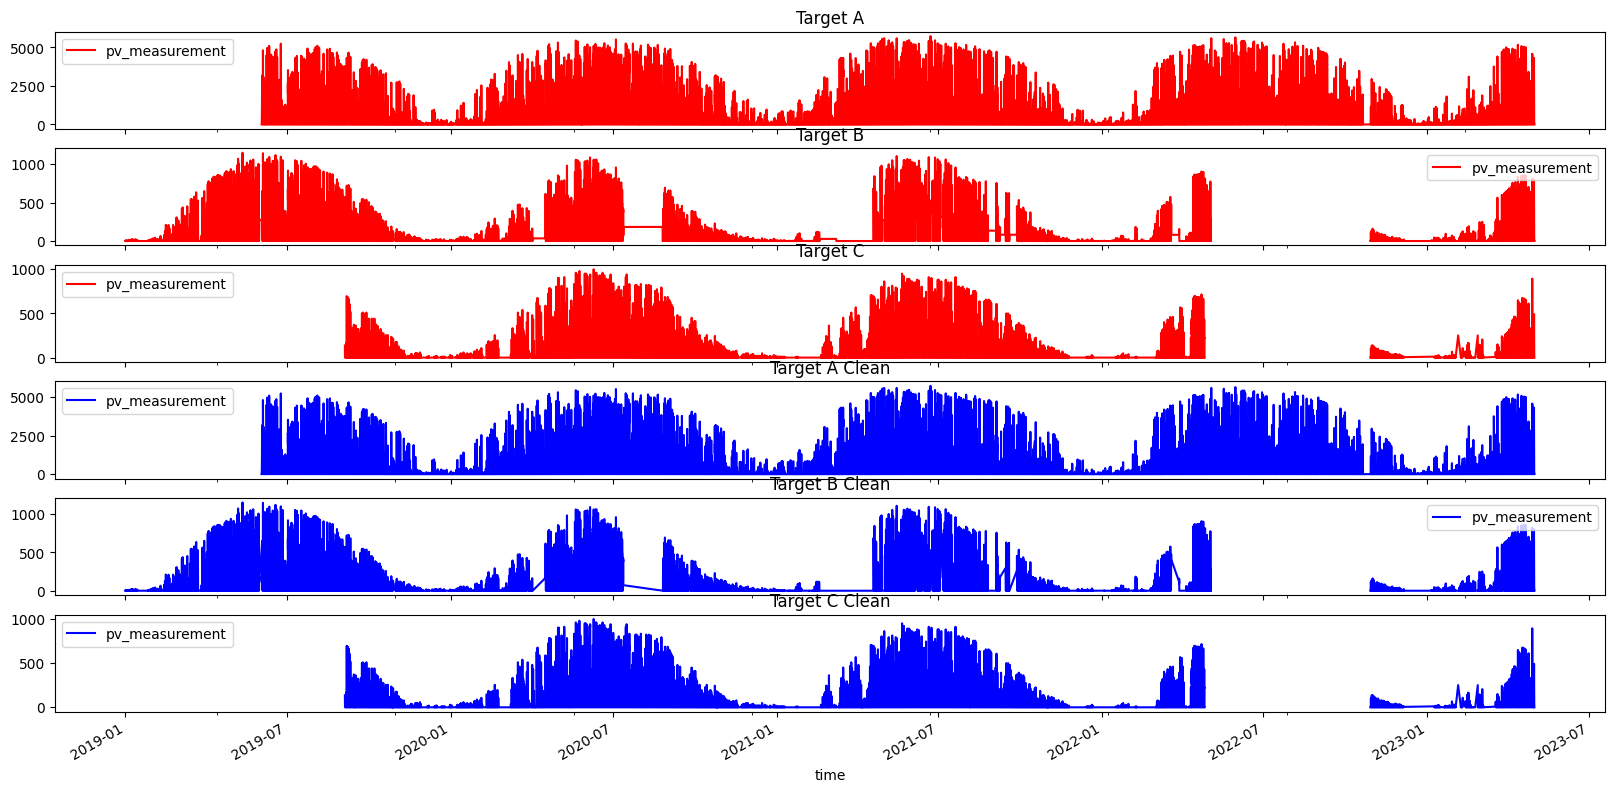

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [7]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


In [9]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

34055   2023-04-30 19:00:00
34056   2023-04-30 20:00:00
34057   2023-04-30 21:00:00
34058   2023-04-30 22:00:00
34059   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
29591   2023-04-30 19:00:00
29592   2023-04-30 20:00:00
29593   2023-04-30 21:00:00
29594   2023-04-30 22:00:00
29595   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
26023   2023-04-30 19:00:00
26024   2023-04-30 20:00:00
26025   2023-04-30 21:00:00
26026   2023-04-30 22:00:00
26027   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [10]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


## Data Cleaning

In [11]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4588,5122
cloud_base_agl:m,2362,2025,2199
snow_density:kgm3,32920,28040,24561


In [12]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
precip_type_5min:idx_5,720,720,720


In [13]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

# Prep data for stacking models

In [14]:
def split_data_for_stacking(x: pd.DataFrame) -> [pd.DataFrame]:
    '''
    Splits data linearly in 60%, 35%, and 5%
    Returns dataframes in order with this split
    '''
    length = len(x)
    fifty_end = int(length*0.6)
    forty_end = int(length*0.35 + fifty_end)
    print(f"Dataframe of lenght {length} splits up into 60%: [0:{fifty_end}], 35%: [{fifty_end}, {forty_end}], 5%: [{forty_end}, {length-1}]")
    fifty = x.iloc[:fifty_end]
    forty = x.iloc[fifty_end:forty_end]
    ten = x.iloc[forty_end:]
    print(f'{len(fifty)} + {len(forty)} + {len(ten)} = {len(fifty)+len(forty)+len(ten)}')
    return [fifty, forty, ten]

In [15]:
x_l0_train_a, x_l1_train_a, x_l1_test_a = split_data_for_stacking(X_train[0])
y_l0_train_a, y_l1_train_a, y_l1_test_a = split_data_for_stacking(Y_train[0])
x_l0_train_b, x_l1_train_b, x_l1_test_b = split_data_for_stacking(X_train[1])
y_l0_train_b, y_l1_train_b, y_l1_test_b = split_data_for_stacking(Y_train[1])
x_l0_train_c, x_l1_train_c, x_l1_test_c = split_data_for_stacking(X_train[2])
y_l0_train_c, y_l1_train_c, y_l1_test_c = split_data_for_stacking(Y_train[2])

Dataframe of lenght 34060 splits up into 60%: [0:20436], 35%: [20436, 32357], 5%: [32357, 34059]
20436 + 11921 + 1703 = 34060
Dataframe of lenght 34060 splits up into 60%: [0:20436], 35%: [20436, 32357], 5%: [32357, 34059]
20436 + 11921 + 1703 = 34060
Dataframe of lenght 29596 splits up into 60%: [0:17757], 35%: [17757, 28115], 5%: [28115, 29595]
17757 + 10358 + 1481 = 29596
Dataframe of lenght 29596 splits up into 60%: [0:17757], 35%: [17757, 28115], 5%: [28115, 29595]
17757 + 10358 + 1481 = 29596
Dataframe of lenght 26028 splits up into 60%: [0:15616], 35%: [15616, 24725], 5%: [24725, 26027]
15616 + 9109 + 1303 = 26028
Dataframe of lenght 26028 splits up into 60%: [0:15616], 35%: [15616, 24725], 5%: [24725, 26027]
15616 + 9109 + 1303 = 26028


# Training L0 XGBOOST

In [16]:
import xgboost as xgb

In [17]:
# hyper parameters from optuna
params_a = {'random_state': 42, 'n_estimators': 980, 'max_depth': 9, 'learning_rate': 0.029035565559484028, 'subsample': 0.8393121619033767, 'colsample_bytree': 0.7589542758688459}
params_b = {'random_state': 42, 'n_estimators': 955, 'max_depth': 9, 'learning_rate': 0.02949625834198986, 'subsample': 0.8030196155828968, 'colsample_bytree': 0.72518389089994}
params_c = {'random_state': 42, 'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.08609213174337473, 'subsample': 0.8107057409889747, 'colsample_bytree': 0.8763563332327975}
model_xg_a_l0 = xgb.XGBRegressor(**params_a)
model_xg_b_l0 = xgb.XGBRegressor(**params_b)
model_xg_c_l0 = xgb.XGBRegressor(**params_c)

In [18]:
model_xg_a_l0.fit(x_l0_train_a, y_l0_train_a)
model_xg_b_l0.fit(x_l0_train_b, y_l0_train_b)
model_xg_c_l0.fit(x_l0_train_c, y_l0_train_c)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8763563332327975, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08609213174337473, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=727, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Evaluating on L1_training data

In [19]:
# Evaluate the model based on the validation data
from sklearn.metrics import mean_absolute_error

mae_a = mean_absolute_error(y_l1_train_a, model_xg_a_l0.predict(x_l1_train_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_l1_train_b, model_xg_b_l0.predict(x_l1_train_b))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_l1_train_c, model_xg_c_l0.predict(x_l1_train_c))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

# Evaluate the predictions

score_a = model_xg_a_l0.score(x_l1_train_a, y_l1_train_a)
score_b = model_xg_b_l0.score(x_l1_train_b, y_l1_train_b)
score_c = model_xg_c_l0.score(x_l1_train_c, y_l1_train_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_xg_a_l0, 'A'), (model_xg_b_l0, 'B'), (model_xg_c_l0, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_l0_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    pd.set_option('display.max_rows', 500)
    feature_importance_df1.head(500)
    print(f'Model {model[1]}')
    print(feature_importance_df1)
    pd.reset_option('display.max_rows')


MAE for A:  158.41205679564536
MAE for B:  30.410065158052973
MAE for C:  19.42078064359554
Mean MAE:  69.41430086576463
Score A:  0.8646955224238415
Score B:  0.8365092843256435
Score C:  0.879085822700766

Model A
                           Feature  Importance
11                    direct_rad:W    0.357016
12                 direct_rad_1h:J    0.189784
9                    diffuse_rad:W    0.062465
6                  clear_sky_rad:W    0.039979
48          precip_type_5min:idx_0    0.030058
32                 sun_elevation:d    0.028333
20                  precip_5min:mm    0.026017
31                   sun_azimuth:d    0.021281
41                       sinus_day    0.014978
44                    cosinus_year    0.014684
13         effective_cloud_cover:p    0.013127
49          precip_type_5min:idx_1    0.012256
35             total_cloud_cover:p    0.011310
24                 rain_water:kgm2    0.010841
43                      sinus_year    0.010503
30                 snow_water:kg

# Training L0 Neural Network

In [20]:
import tensorflow as tf

In [21]:
normalizer_A = tf.keras.layers.Normalization(axis=-1)
normalizer_A.adapt(X_train[0])

first = np.array(X_train[0][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_A(first).numpy())

normalizer_B = tf.keras.layers.Normalization(axis=-1)
normalizer_B.adapt(X_train[1])
normalizer_C = tf.keras.layers.Normalization(axis=-1)
normalizer_C.adapt(X_train[2])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

First example: [[    0.       1.       7.7      1.23  1728.95     0.       0.    1728.95
    280.3      0.       0.       0.       0.      99.07     0.       0.
      0.       0.       0.    1006.3      0.     993.75   999.78     0.
      0.      71.67  1005.8      0.       0.       0.       0.17   348.04
     -3.77     0.     286.23   100.   40386.48     3.6     -3.57    -0.5
      0.      -0.5      0.87     0.49    -0.87     0.       1.       0.
      1.       0.       0.       0.       0.  ]]

Normalized: [[-0.97  0.95  0.49 -0.67 -0.62 -0.65 -0.65 -0.26  0.63 -0.67 -0.68 -0.46
  -0.46  0.93 -0.15 -0.09 -0.19 -0.1  -0.12 -0.26 -0.2  -0.23 -0.24 -0.08
  -0.25 -0.17 -0.25 -0.16  0.   -0.05  0.36  1.72 -0.15 -0.54  0.94  0.77
   0.44  0.3  -1.46 -0.58 -0.01 -0.71  1.22  0.71 -1.25 -0.09  0.19 -0.17
   0.24 -0.21 -0.07 -0.08 -0.01]]


In [22]:

model_tf_a_l0 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=53),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_A, 
    tf.keras.layers.Dense(1024, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_tf_a_l0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss="mae", 
                metrics=["mae", "mse"])

history_a = model_tf_a_l0.fit(x=x_l0_train_a, y=y_l0_train_a, epochs=500, callbacks=[early_stop], validation_split=0.2)

Epoch 1/500
511/511 [==============================] - 1s 2ms/step - loss: 339.0218 - mae: 339.0218 - mse: 620384.6875 - val_loss: 376.6574 - val_mae: 376.6574 - val_mse: 445193.1250
Epoch 2/500
511/511 [==============================] - 1s 2ms/step - loss: 257.3979 - mae: 257.3979 - mse: 347002.9375 - val_loss: 354.4997 - val_mae: 354.4997 - val_mse: 406894.2188
Epoch 3/500
511/511 [==============================] - 1s 2ms/step - loss: 245.9370 - mae: 245.9370 - mse: 318715.7500 - val_loss: 353.5505 - val_mae: 353.5505 - val_mse: 400105.0000
Epoch 4/500
511/511 [==============================] - 1s 2ms/step - loss: 244.7066 - mae: 244.7066 - mse: 314583.0312 - val_loss: 340.4556 - val_mae: 340.4556 - val_mse: 387210.2500
Epoch 5/500
511/511 [==============================] - 1s 2ms/step - loss: 243.5619 - mae: 243.5619 - mse: 314853.1875 - val_loss: 331.3745 - val_mae: 331.3745 - val_mse: 373167.5312
Epoch 6/500
511/511 [==============================] - 1s 2ms/step - loss: 242.2411 -

In [23]:
model_tf_a_l0.evaluate(x_l1_train_a, y_l1_train_a)

373/373 [==============================] - 0s 534us/step - loss: 168.5527 - mae: 168.5527 - mse: 225006.0469


[168.55274963378906, 168.55274963378906, 225006.046875]

In [24]:
model_tf_b_l0 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=53),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_B, 
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1)
])

model_tf_b_l0.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), 
                loss="mse", 
                metrics=["mae", "mse"])

history_b = model_tf_b_l0.fit(x=x_l0_train_b, y=y_l0_train_b, epochs=500, callbacks=[early_stop], validation_split=0.2)

Epoch 1/500
444/444 [==============================] - 1s 877us/step - loss: 15444.4648 - mae: 55.6147 - mse: 15444.4648 - val_loss: 4131.2671 - val_mae: 21.0939 - val_mse: 4131.2671
Epoch 2/500
444/444 [==============================] - 0s 662us/step - loss: 5624.9282 - mae: 35.1714 - mse: 5624.9282 - val_loss: 4483.9199 - val_mae: 20.7973 - val_mse: 4483.9199
Epoch 3/500
444/444 [==============================] - 0s 664us/step - loss: 5452.4165 - mae: 33.9687 - mse: 5452.4165 - val_loss: 3661.7043 - val_mae: 18.1725 - val_mse: 3661.7043
Epoch 4/500
444/444 [==============================] - 0s 655us/step - loss: 5227.7275 - mae: 33.1059 - mse: 5227.7275 - val_loss: 3620.6506 - val_mae: 18.3456 - val_mse: 3620.6506
Epoch 5/500
444/444 [==============================] - 0s 663us/step - loss: 5203.7144 - mae: 32.8429 - mse: 5203.7144 - val_loss: 4030.8064 - val_mae: 19.4047 - val_mse: 4030.8064
Epoch 6/500
444/444 [==============================] - 0s 663us/step - loss: 5104.4155 - mae:

In [25]:
model_tf_b_l0.evaluate(x_l1_train_b, y_l1_train_b)

324/324 [==============================] - 0s 427us/step - loss: 6958.6182 - mae: 31.4511 - mse: 6958.6182


[6958.6181640625, 31.451093673706055, 6958.6181640625]

In [26]:
model_tf_c_l0 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=53),
    #ak.MultiCategoryEncoding(encoding=['int','int','int','int','none','none','none','none','none',
    #                                   'none','none','none','none','none','int','int','int','int',
    #                                   'int','none','int','none','none','int','int','none','none',
    #                                   'int','int','int','int','none','none','int','none','none',
    #                                   'none','int','int','int','int','int','int','none','none',
    #                                   'int','int','int','int','int','int','int','int']),
    normalizer_C, 
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

model_tf_c_l0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss="mae", 
                metrics=["mae", "mse", 'accuracy'])

history_c = model_tf_c_l0.fit(x=x_l0_train_c, y=y_l0_train_c, epochs=500, callbacks=[early_stop], validation_split=0.2)

Epoch 1/500
391/391 [==============================] - 1s 828us/step - loss: 56.1909 - mae: 56.1909 - mse: 20599.5742 - accuracy: 0.4963 - val_loss: 47.6221 - val_mae: 47.6221 - val_mse: 8378.2910 - val_accuracy: 0.4334
Epoch 2/500
391/391 [==============================] - 0s 604us/step - loss: 31.7997 - mae: 31.7997 - mse: 6375.9404 - accuracy: 0.5752 - val_loss: 41.9979 - val_mae: 41.9979 - val_mse: 6485.1865 - val_accuracy: 0.4389
Epoch 3/500
391/391 [==============================] - 0s 596us/step - loss: 30.8666 - mae: 30.8666 - mse: 6000.8804 - accuracy: 0.5797 - val_loss: 39.2123 - val_mae: 39.2123 - val_mse: 5764.6426 - val_accuracy: 0.4363
Epoch 4/500
391/391 [==============================] - 0s 599us/step - loss: 30.2504 - mae: 30.2504 - mse: 5735.8291 - accuracy: 0.5789 - val_loss: 40.1125 - val_mae: 40.1125 - val_mse: 6116.4697 - val_accuracy: 0.4421
Epoch 5/500
391/391 [==============================] - 0s 598us/step - loss: 30.2217 - mae: 30.2217 - mse: 5920.7427 - accu

In [27]:
model_tf_c_l0.evaluate(x_l1_train_c, y_l1_train_c)

  1/285 [..............................] - ETA: 3s - loss: 54.3399 - mae: 54.3399 - mse: 8596.1943 - accuracy: 0.2812

285/285 [==============================] - 0s 457us/step - loss: 17.9356 - mae: 17.9356 - mse: 2371.8542 - accuracy: 0.6165


[17.935562133789062, 17.935562133789062, 2371.854248046875, 0.616533100605011]

# Training L1 XGBOOST

In [28]:
xg_l0_a = model_xg_a_l0.predict(x_l1_train_a)
xg_l0_b = model_xg_b_l0.predict(x_l1_train_b)
xg_l0_c = model_xg_c_l0.predict(x_l1_train_c)

tf_l0_a = model_tf_a_l0.predict(x_l1_train_a)
tf_l0_b = model_tf_b_l0.predict(x_l1_train_b)
tf_l0_c = model_tf_c_l0.predict(x_l1_train_c)

285/285 [==============================] - 0s 351us/step


In [29]:
#since tensorflow model returns array with array we need to make it a regular list
tf_l0_a_list = [item[0] for item in tf_l0_a]
tf_l0_b_list = [item[0] for item in tf_l0_b]
tf_l0_c_list = [item[0] for item in tf_l0_c]

In [30]:
xg_a = pd.Series(xg_l0_a)
xg_b = pd.Series(xg_l0_b)
xg_c = pd.Series(xg_l0_c)

tf_a = pd.Series(tf_l0_a_list)
tf_b = pd.Series(tf_l0_b_list)
tf_c = pd.Series(tf_l0_c_list)



xg_a.rename("xg_a", inplace=True)
xg_b.rename("xg_b", inplace=True)
xg_c.rename("xg_c", inplace=True)

tf_a.rename("tf_a", inplace=True)
tf_b.rename("tf_b", inplace=True)
tf_c.rename("tf_c", inplace=True)
print(tf_a.tail())
print(xg_a.tail())


11916    0.000097
11917    0.000097
11918    0.000097
11919    0.000097
11920    0.000097
Name: tf_a, dtype: float32
11916   -2.721146
11917   -3.053874
11918   -2.833655
11919    1.294887
11920    0.035399
Name: xg_a, dtype: float32


In [31]:
df_a = pd.merge(xg_a, tf_a, left_index=True, right_index=True)
df_b = pd.merge(xg_b, tf_b, left_index=True, right_index=True)
df_c = pd.merge(xg_c, tf_c, left_index=True, right_index=True)

In [32]:
df_a.tail()

,xg_a,tf_a
11916,-2.721146,0.000097
11917,-3.053874,0.000097
11918,-2.833655,0.000097
11919,1.294887,0.000097
11920,0.035399,0.000097


In [33]:
model_xg_a_l1 = xgb.XGBRegressor(**params_a)
model_xg_b_l1 = xgb.XGBRegressor(**params_b)
model_xg_c_l1 = xgb.XGBRegressor(**params_c)

In [34]:
model_xg_a_l1.fit(df_a, y_l1_train_a)
model_xg_b_l1.fit(df_b, y_l1_train_b)
model_xg_c_l1.fit(df_c, y_l1_train_c)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8763563332327975, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08609213174337473, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=727, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Evaluate on L1 test data

In [35]:
# Evaluate the model based on the validation data
from sklearn.metrics import mean_absolute_error

xg_l1_a = model_xg_a_l0.predict(x_l1_test_a)
xg_l1_b = model_xg_b_l0.predict(x_l1_test_b)
xg_l1_c = model_xg_c_l0.predict(x_l1_test_c)

tf_l1_a = model_tf_a_l0.predict(x_l1_test_a)
tf_l1_b = model_tf_b_l0.predict(x_l1_test_b)
tf_l1_c = model_tf_c_l0.predict(x_l1_test_c)

tf_l1_a_list = [item[0] for item in tf_l1_a]
tf_l1_b_list = [item[0] for item in tf_l1_b]
tf_l1_c_list = [item[0] for item in tf_l1_c]

xg_a_l1 = pd.Series(xg_l1_a)
xg_b_l1 = pd.Series(xg_l1_b)
xg_c_l1 = pd.Series(xg_l1_c)

tf_a_l1 = pd.Series(tf_l1_a_list)
tf_b_l1 = pd.Series(tf_l1_b_list)
tf_c_l1 = pd.Series(tf_l1_c_list)

xg_a_l1.rename("xg_a", inplace=True)
xg_b_l1.rename("xg_b", inplace=True)
xg_c_l1.rename("xg_c", inplace=True)

tf_a_l1.rename("tf_a", inplace=True)
tf_b_l1.rename("tf_b", inplace=True)
tf_c_l1.rename("tf_c", inplace=True)

df_a_l1 = pd.merge(xg_a_l1, tf_a_l1, left_index=True, right_index=True)
df_b_l1 = pd.merge(xg_b_l1, tf_b_l1, left_index=True, right_index=True)
df_c_l1 = pd.merge(xg_c_l1, tf_c_l1, left_index=True, right_index=True)


41/41 [==============================] - 0s 357us/step


In [36]:
mae_a = mean_absolute_error(y_l1_test_a, model_xg_a_l1.predict(df_a_l1))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_l1_test_b, model_xg_b_l1.predict(df_b_l1))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_l1_test_c, model_xg_c_l1.predict(df_c_l1))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

# Evaluate the predictions

score_a = model_xg_a_l1.score(df_a_l1, y_l1_test_a)
score_b = model_xg_b_l1.score(df_b_l1, y_l1_test_b)
score_c = model_xg_c_l1.score(df_c_l1, y_l1_test_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

MAE for A:  231.08562464424782
MAE for B:  37.461481515970405
MAE for C:  35.9404879526054
Mean MAE:  101.49586470427454
Score A:  0.863755277517449
Score B:  0.8399349883543987
Score C:  0.791998537728394



## Training L1 Neural Network

In [37]:
import autokeras as ak
model_a = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 20,
    loss="mean_absolute_error",
    project_name="custom_stack_l1_A"
)

model_a.fit(
    x = df_a,
    y = y_l1_train_a
)


Trial 20 Complete [00h 00m 04s]
val_loss: 44.01335906982422

Best val_loss So Far: 42.493408203125
Total elapsed time: 00h 04m 50s


Epoch 1/8
373/373 [==============================] - 0s 604us/step - loss: 368.4276 - mean_squared_error: 835758.0000
Epoch 2/8
373/373 [==============================] - 0s 567us/step - loss: 153.6350 - mean_squared_error: 156691.0312
Epoch 3/8
373/373 [==============================] - 0s 621us/step - loss: 151.1592 - mean_squared_error: 156827.1562
Epoch 4/8
373/373 [==============================] - 0s 566us/step - loss: 150.9608 - mean_squared_error: 156942.0312
Epoch 5/8
373/373 [==============================] - 0s 570us/step - loss: 150.8588 - mean_squared_error: 157096.0156
Epoch 6/8
373/373 [==============================] - 0s 574us/step - loss: 150.6745 - mean_squared_error: 157131.3594
Epoch 7/8
373/373 [==============================] - 0s 570us/step - loss: 150.6254 - mean_squared_error: 157203.9531
Epoch 8/8
373/373 [==============================] - 0s 576us/step - loss: 150.5380 - mean_squared_error: 157236.9688
INFO:tensorflow:Assets written to: ./custom_stack_l1_A/b

INFO:tensorflow:Assets written to: ./custom_stack_l1_A/best_model/assets


In [38]:
tf_best_l1_a = model_a.export_model()

In [39]:
tf_best_l1_a.save('./tensorflow_models/tf_best_l1_a_05_11.keras')

In [40]:
model_b_l1 = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 20,
    loss="mean_absolute_error",
    project_name="custom_stack_l1_B"
)

model_b_l1.fit(
    x = df_b,
    y = y_l1_train_b
)

Trial 20 Complete [00h 00m 04s]
val_loss: 4.1681718826293945

Best val_loss So Far: 3.609686851501465
Total elapsed time: 00h 05m 18s


Epoch 1/6
324/324 [==============================] - 0s 658us/step - loss: 64.7301 - mean_squared_error: 29475.7500
Epoch 2/6
324/324 [==============================] - 0s 655us/step - loss: 31.9542 - mean_squared_error: 6575.5527
Epoch 3/6
324/324 [==============================] - 0s 645us/step - loss: 29.9477 - mean_squared_error: 6315.6611
Epoch 4/6
324/324 [==============================] - 0s 615us/step - loss: 29.7496 - mean_squared_error: 6304.9478
Epoch 5/6
324/324 [==============================] - 0s 601us/step - loss: 29.6100 - mean_squared_error: 6301.9082
Epoch 6/6
324/324 [==============================] - 0s 690us/step - loss: 29.5303 - mean_squared_error: 6300.8750
INFO:tensorflow:Assets written to: ./custom_stack_l1_B/best_model/assets


INFO:tensorflow:Assets written to: ./custom_stack_l1_B/best_model/assets


In [41]:
tf_best_l1_b = model_b_l1.export_model()
tf_best_l1_b.save('./tensorflow_models/tf_best_l1_b_05_11.keras')

In [42]:
model_c_l1 = ak.StructuredDataRegressor(
    overwrite=True,
    max_trials= 20,
    loss="mean_absolute_error",
    project_name="custom_stack_l1_C"
)

model_c_l1.fit(
    x = df_c,
    y = y_l1_train_c
)

Trial 20 Complete [00h 00m 12s]
val_loss: 5.940268516540527

Best val_loss So Far: 5.940268516540527
Total elapsed time: 00h 07m 13s


Epoch 1/59
285/285 [==============================] - 0s 514us/step - loss: 72.0969 - mean_squared_error: 33247.9375
Epoch 2/59
285/285 [==============================] - 0s 459us/step - loss: 70.2156 - mean_squared_error: 31718.0957
Epoch 3/59
285/285 [==============================] - 0s 454us/step - loss: 68.0448 - mean_squared_error: 29953.7598
Epoch 4/59
285/285 [==============================] - 0s 462us/step - loss: 65.8449 - mean_squared_error: 28215.4355
Epoch 5/59
285/285 [==============================] - 0s 463us/step - loss: 63.6585 - mean_squared_error: 26539.9082
Epoch 6/59
285/285 [==============================] - 0s 461us/step - loss: 61.5564 - mean_squared_error: 24950.3242
Epoch 7/59
285/285 [==============================] - 0s 454us/step - loss: 59.5403 - mean_squared_error: 23452.8203
Epoch 8/59
285/285 [==============================] - 0s 536us/step - loss: 57.5968 - mean_squared_error: 22040.8027
Epoch 9/59
285/285 [==============================] - 0s 464us/s

INFO:tensorflow:Assets written to: ./custom_stack_l1_C/best_model/assets


In [43]:
tf_best_l1_c = model_c_l1.export_model()
tf_best_l1_c.save('./tensorflow_models/tf_best_l1_c_05_11.keras')

### Evaluate L1 Neural Network

In [44]:
mae_a = mean_absolute_error(y_l1_test_a, tf_best_l1_a.predict(df_a_l1))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_l1_test_b, tf_best_l1_b.predict(df_b_l1))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_l1_test_c, tf_best_l1_c.predict(df_c_l1))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

54/54 [==============================] - 0s 657us/step
MAE for A:  217.65287688522886
47/47 [==============================] - 0s 512us/step
MAE for B:  32.431330991194436
41/41 [==============================] - 0s 393us/step
MAE for C:  35.354470832282445
Mean MAE:  95.14622623623525


# Make predictions for both L1 models

In [45]:
# L0 predictions
xg_l0_a_test = model_xg_a_l0.predict(X_frames_test[0])
xg_l0_b_test = model_xg_b_l0.predict(X_frames_test[1])
xg_l0_c_test = model_xg_c_l0.predict(X_frames_test[2])

tf_l0_a_test = model_tf_a_l0.predict(X_frames_test[0])
tf_l0_b_test = model_tf_b_l0.predict(X_frames_test[1])
tf_l0_c_test = model_tf_c_l0.predict(X_frames_test[2])

tf_l0_a_test_list = [item[0] for item in tf_l0_a_test]
tf_l0_b_test_list = [item[0] for item in tf_l0_b_test]
tf_l0_c_test_list = [item[0] for item in tf_l0_c_test]

23/23 [==============================] - 0s 528us/step


In [46]:
#prepping for L1

xg_a_l1_test = pd.Series(xg_l0_a_test)
xg_b_l1_test = pd.Series(xg_l0_b_test)
xg_c_l1_test = pd.Series(xg_l0_c_test)

tf_a_l1_test = pd.Series(tf_l0_a_test_list)
tf_b_l1_test = pd.Series(tf_l0_b_test_list)
tf_c_l1_test = pd.Series(tf_l0_c_test_list)

xg_a_l1_test.rename("xg_a", inplace=True)
xg_b_l1_test.rename("xg_b", inplace=True)
xg_c_l1_test.rename("xg_c", inplace=True)

tf_a_l1_test.rename("tf_a", inplace=True)
tf_b_l1_test.rename("tf_b", inplace=True)
tf_c_l1_test.rename("tf_c", inplace=True)

df_a_l1_test = pd.merge(xg_a_l1_test, tf_a_l1_test, left_index=True, right_index=True)
df_b_l1_test = pd.merge(xg_b_l1_test, tf_b_l1_test, left_index=True, right_index=True)
df_c_l1_test = pd.merge(xg_c_l1_test, tf_c_l1_test, left_index=True, right_index=True)

In [47]:
# Neural Network prediction
tf_l1_pred_a = tf_best_l1_a.predict(df_a_l1_test)
tf_l1_pred_b = tf_best_l1_b.predict(df_b_l1_test)
tf_l1_pred_c = tf_best_l1_c.predict(df_c_l1_test)

# XGBOOST prediction
xg_l1_pred_a = model_xg_a_l1.predict(df_a_l1_test)
xg_l1_pred_b = model_xg_b_l1.predict(df_b_l1_test)
xg_l1_pred_c = model_xg_c_l1.predict(df_c_l1_test)

23/23 [==============================] - 0s 721us/step


23/23 [==============================] - 0s 555us/step


In [48]:
tf_l1_pred_a_list = [item[0] for item in tf_l1_pred_a]
tf_l1_pred_b_list = [item[0] for item in tf_l1_pred_b]
tf_l1_pred_c_list = [item[0] for item in tf_l1_pred_c]

tf_l1_pred_a_arr = np.array(tf_l1_pred_a_list)
tf_l1_pred_b_arr = np.array(tf_l1_pred_b_list)
tf_l1_pred_c_arr = np.array(tf_l1_pred_c_list)

In [49]:
xg_pred = np.concatenate((xg_l1_pred_a, xg_l1_pred_b, xg_l1_pred_c), axis=0)
tf_pred = np.concatenate((tf_l1_pred_a_arr, tf_l1_pred_b_arr, tf_l1_pred_c_arr), axis=0)

In [50]:
print("Length test data:", len(X_frames_test[0])*3)
print("Length xg_pred:", len(xg_pred))
print("Length tf_pred:", len(tf_pred))

Length test data: 2160
Length xg_pred: 2160
Length tf_pred: 2160


# Create submission

In [51]:
# XG L1
y_test_pred_xg = xg_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred_xg
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/custom_stack_l1XG_submission.csv', index=False)

In [52]:
# TF L1
y_test_pred_tf = tf_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred_tf
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/custom_stack_l1TF_submission.csv', index=False)